In [40]:
import gzip         # for reading .pkl.gz
import pickle       # to load the pickled dicts
import numpy as np  # for arrays, math
import matplotlib.pyplot as plt  # for plotting
from sklearn.metrics import r2_score
from scipy.stats import linregress
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks, peak_prominences, peak_widths
import matplotlib.cm as cm



In [3]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

Grounding Line plotting - Bedrock Erosion = 1.0 e -9

In [4]:
gl_run_title_be_1e9 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-9")
be_1e9 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run1_be1E-9/DATA_Dictionary_2025_03_24__13_32_47.pkl.gz"
with gzip.open(be_1e9, 'rb') as f:
    DATA_dict_be_1e9 = pickle.load(f)

In [5]:
bed_dict = DATA_dict_be_1e9['bed_dict']
base_dict = DATA_dict_be_1e9['base_dict']
surf_dict= DATA_dict_be_1e9 ['surf_dict']
sed_dict = DATA_dict_be_1e9['sed_dict']
H_dict = DATA_dict_be_1e9['H_dict']
us_dict = DATA_dict_be_1e9['us_dict']
ub_dict = DATA_dict_be_1e9['ub_dict']
Hs_dict = DATA_dict_be_1e9['Hs_dict']
GL_dict = DATA_dict_be_1e9['GL_dict']
Qs_dict = DATA_dict_be_1e9['Qs_dict']

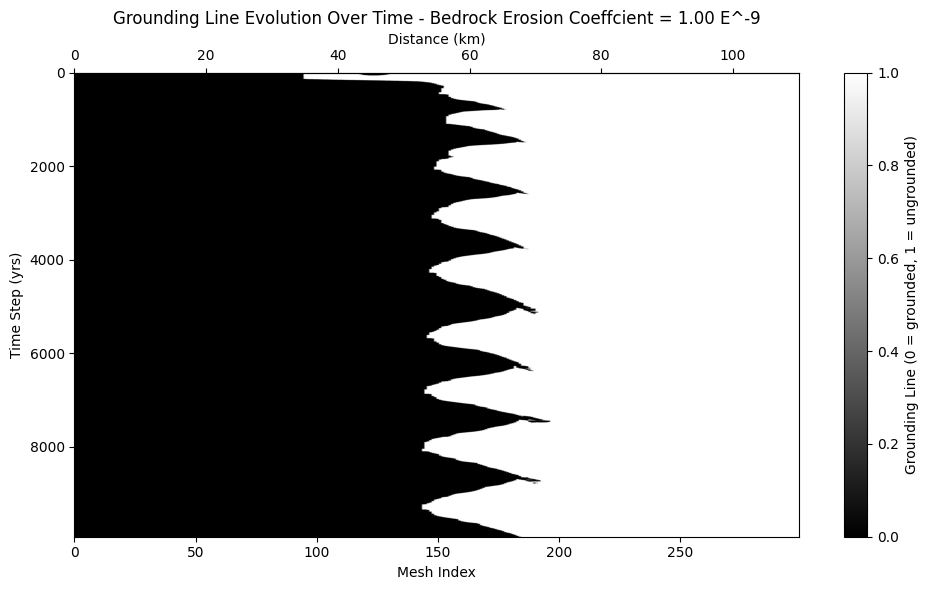

In [6]:
GL_dict = DATA_dict_be_1e9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [7]:
gl_positions_be_1e9 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_1e9.append(idx)

gl_positions_be_1e9 = np.array(gl_positions_be_1e9)
GL_km_be_1e9 = mesh_index_to_km(gl_positions_be_1e9)

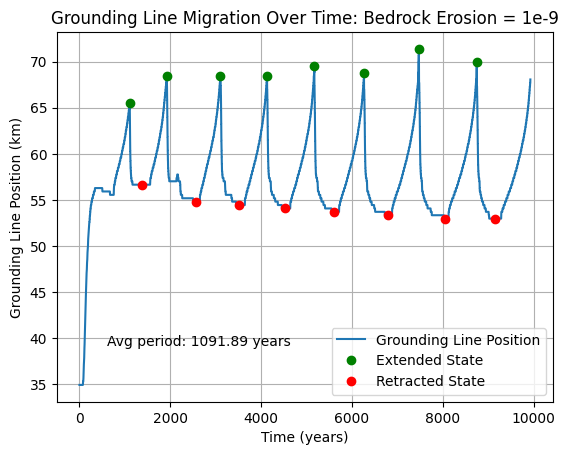

Mean cycle period: 1091.89 years
[ 817.42712774 1180.905683   1025.49975412 1041.53002828 1094.87646329
 1209.04509811 1273.92375981]
Mean advance amplitude: 68.80 km
[65.48494983 68.42809365 68.42809365 68.42809365 69.53177258 68.79598662
 71.37123746 69.89966555]
Mean retreat amplitude: 54.13 km
[56.65551839 54.81605351 54.44816054 54.08026756 53.71237458 53.34448161
 52.97658863 52.97658863]


In [8]:
peaks_be_1e9, _ = find_peaks(GL_km_be_1e9, prominence=1) 
torughs_be_1e9, _ = find_peaks(-GL_km_be_1e9, prominence=2)     
periods_be_1e9 = np.diff(np.array(time)[peaks_be_1e9])
adv_dists_be_1e9 = GL_km_be_1e9[peaks_be_1e9]
ret_dists__be_1e9 = GL_km_be_1e9[torughs_be_1e9]


plt.plot(time, GL_km_be_1e9, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_1e9], GL_km_be_1e9[peaks_be_1e9], 'go', label='Extended State')
plt.plot(np.array(time)[torughs_be_1e9], GL_km_be_1e9[torughs_be_1e9], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_1e9):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 1e-9")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_1e9):.2f} years")
print(periods_be_1e9)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_1e9):.2f} km")
print(adv_dists_be_1e9)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_1e9):.2f} km")
print(ret_dists__be_1e9)


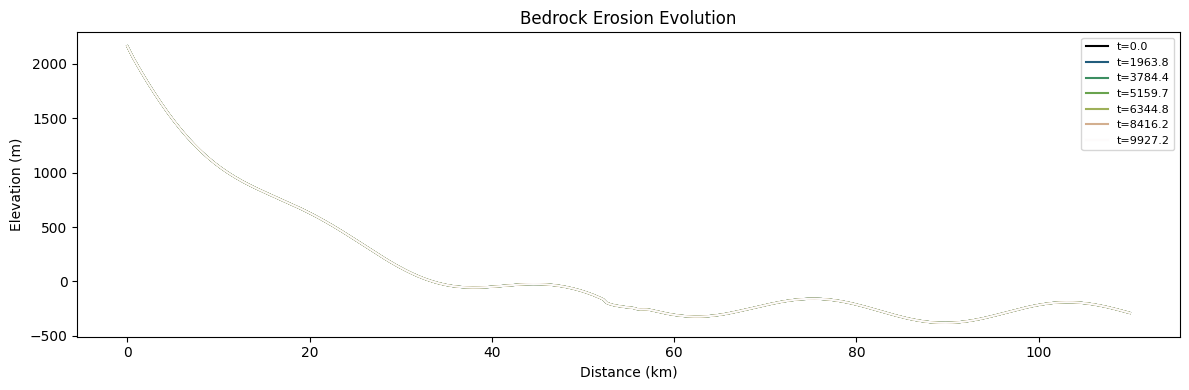

In [9]:
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.gist_earth

plt.figure(figsize=(12,4))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution")
# plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(35,70)
# plt.ylim(-500,200)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

Grounding Line plotting - Bedrock Erosion = 5.5 e -9


In [10]:
gl_run_title_be_55e9 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 5.5e-9")
be_55e9 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run2_be5.5E-9/DATA_Dictionary_2025_04_13__22_09_00.pkl.gz"
with gzip.open(be_55e9, 'rb') as f:
    DATA_dict_be_55e9 = pickle.load(f)

In [11]:
bed_dict = DATA_dict_be_55e9['bed_dict']
base_dict = DATA_dict_be_55e9['base_dict']
surf_dict= DATA_dict_be_55e9 ['surf_dict']
sed_dict = DATA_dict_be_55e9['sed_dict']
H_dict = DATA_dict_be_55e9['H_dict']
us_dict = DATA_dict_be_55e9['us_dict']
ub_dict = DATA_dict_be_55e9['ub_dict']
Hs_dict = DATA_dict_be_55e9['Hs_dict']
GL_dict = DATA_dict_be_55e9['GL_dict']
Qs_dict = DATA_dict_be_55e9['Qs_dict']

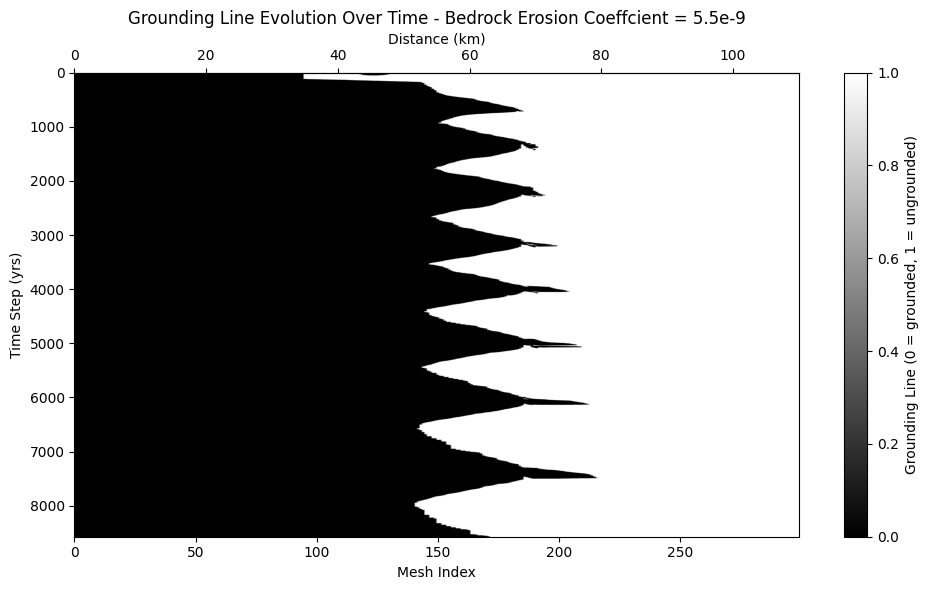

In [12]:
GL_dict = DATA_dict_be_55e9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_55e9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [13]:
gl_positions_be_55e9 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_55e9.append(idx)

gl_positions_be_55e9 = np.array(gl_positions_be_55e9)
GL_km_be_55e9 = mesh_index_to_km(gl_positions_be_55e9)

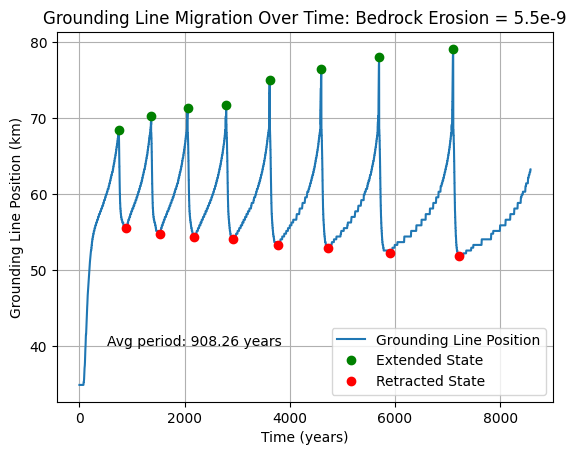

Mean cycle period: 908.26 years
[ 616.84894271  691.56585571  734.45594098  828.22874272  980.06184169
 1098.90079812 1407.77975361]
Mean advance amplitude: 73.81 km
[68.42809365 70.26755853 71.37123746 71.73913043 75.05016722 76.52173913
 77.99331104 79.09698997]
Mean retreat amplitude: 53.67 km
[55.55183946 54.81605351 54.44816054 54.08026756 53.34448161 52.97658863
 52.24080268 51.8729097 ]


In [14]:
peaks_be_55e9, _ = find_peaks(GL_km_be_55e9, prominence=6) 
torughs_be_55e9, _ = find_peaks(-GL_km_be_55e9, prominence=6)     
periods_be_55e9 = np.diff(np.array(time)[peaks_be_55e9])
adv_dists_be_55e9 = GL_km_be_55e9[peaks_be_55e9]
ret_dists__be_55e9 = GL_km_be_55e9[torughs_be_55e9]


plt.plot(time, GL_km_be_55e9, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_55e9], GL_km_be_55e9[peaks_be_55e9], 'go', label='Extended State')
plt.plot(np.array(time)[torughs_be_55e9], GL_km_be_55e9[torughs_be_55e9], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_55e9):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 5.5e-9")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_55e9):.2f} years")
print(periods_be_55e9)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_55e9):.2f} km")
print(adv_dists_be_55e9)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_55e9):.2f} km")
print(ret_dists__be_55e9)


Grounding Line plotting - Bedrock Erosion = 1.0 e -8

In [15]:
gl_run_title_be_1e8 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-8")
be_1e8 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run3_be1E-8/DATA_Dictionary_2025_04_02__11_59_04.pkl.gz"
with gzip.open(be_1e8, 'rb') as f:
    DATA_dict_be_1e8 = pickle.load(f)

In [16]:
bed_dict = DATA_dict_be_1e8['bed_dict']
base_dict = DATA_dict_be_1e8['base_dict']
surf_dict= DATA_dict_be_1e8 ['surf_dict']
sed_dict = DATA_dict_be_1e8['sed_dict']
H_dict = DATA_dict_be_1e8['H_dict']
us_dict = DATA_dict_be_1e8['us_dict']
ub_dict = DATA_dict_be_1e8['ub_dict']
Hs_dict = DATA_dict_be_1e8['Hs_dict']
GL_dict = DATA_dict_be_1e8['GL_dict']
Qs_dict = DATA_dict_be_1e8['Qs_dict']

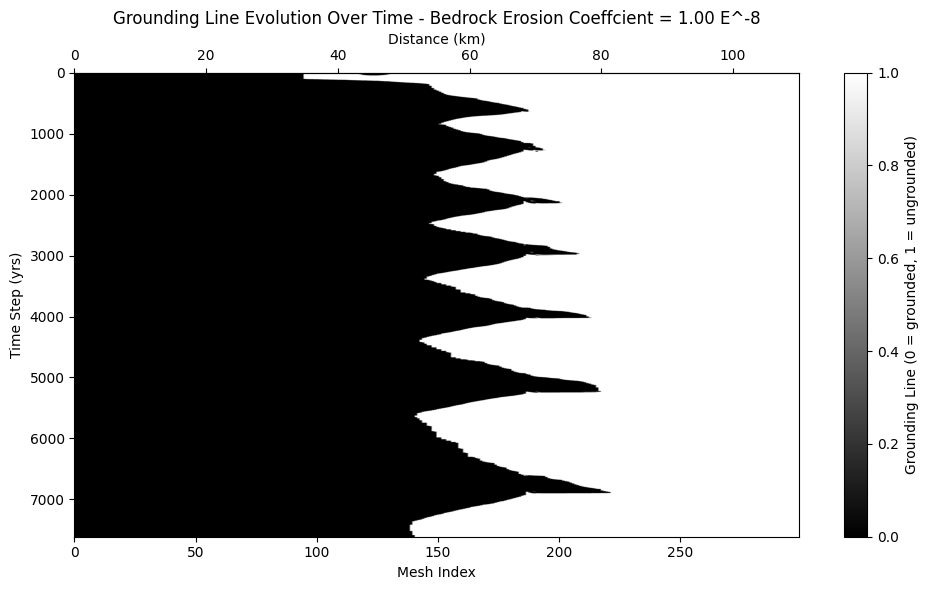

In [17]:
GL_dict = DATA_dict_be_1e8['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [18]:
gl_positions_be_1e8 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_1e8.append(idx)

gl_positions_be_1e8 = np.array(gl_positions_be_1e8)
GL_km_be_1e8 = mesh_index_to_km(gl_positions_be_1e8)

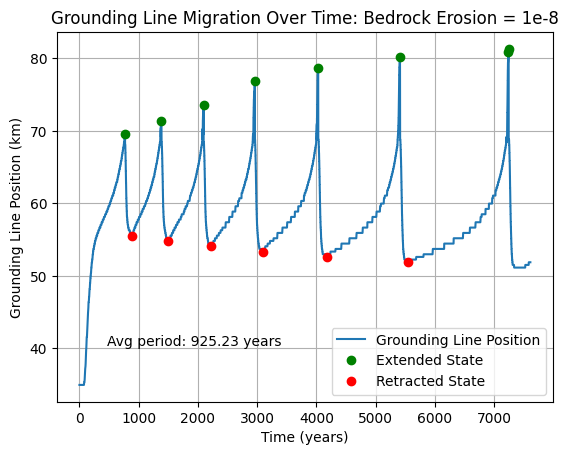

Mean cycle period: 925.23 years
[ 611.66766959  716.0960731   861.7924287  1072.01969453 1379.6762859
 1832.56858383    2.82070982]
Mean advance amplitude: 76.57 km
[69.53177258 71.37123746 73.57859532 76.88963211 78.72909699 80.2006689
 80.93645485 81.30434783]
Mean retreat amplitude: 53.71 km
[55.55183946 54.81605351 54.08026756 53.34448161 52.60869565 51.8729097 ]


In [19]:
peaks_be_1e8, _ = find_peaks(GL_km_be_1e8, prominence=6) 
torughs_be_1e8, _ = find_peaks(-GL_km_be_1e8, prominence=12)     
periods_be_1e8 = np.diff(np.array(time)[peaks_be_1e8])
adv_dists_be_1e8 = GL_km_be_1e8[peaks_be_1e8]
ret_dists__be_1e8 = GL_km_be_1e8[torughs_be_1e8]


plt.plot(time, GL_km_be_1e8, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_1e8], GL_km_be_1e8[peaks_be_1e8], 'go', label='Extended State')
plt.plot(np.array(time)[torughs_be_1e8], GL_km_be_1e8[torughs_be_1e8], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_1e8):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 1e-8")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_1e8):.2f} years")
print(periods_be_1e8)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_1e8):.2f} km")
print(adv_dists_be_1e8)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_1e8):.2f} km")
print(ret_dists__be_1e8)


Grounding Line plotting - Bedrock Erosion = 5.5 e -8

In [20]:
gl_run_title_be_55e8 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 5.5e-8")
be_55e8 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run4_5.5E-8/DATA_Dictionary_2025_04_13__23_47_23.pkl.gz"
with gzip.open(be_55e8, 'rb') as f:
    DATA_dict_be_55e8 = pickle.load(f)

In [21]:
bed_dict = DATA_dict_be_55e8['bed_dict']
base_dict = DATA_dict_be_55e8['base_dict']
surf_dict= DATA_dict_be_55e8 ['surf_dict']
sed_dict = DATA_dict_be_55e8['sed_dict']
H_dict = DATA_dict_be_55e8['H_dict']
us_dict = DATA_dict_be_55e8['us_dict']
ub_dict = DATA_dict_be_55e8['ub_dict']
Hs_dict = DATA_dict_be_55e8['Hs_dict']
GL_dict = DATA_dict_be_55e8['GL_dict']
Qs_dict = DATA_dict_be_55e8['Qs_dict']

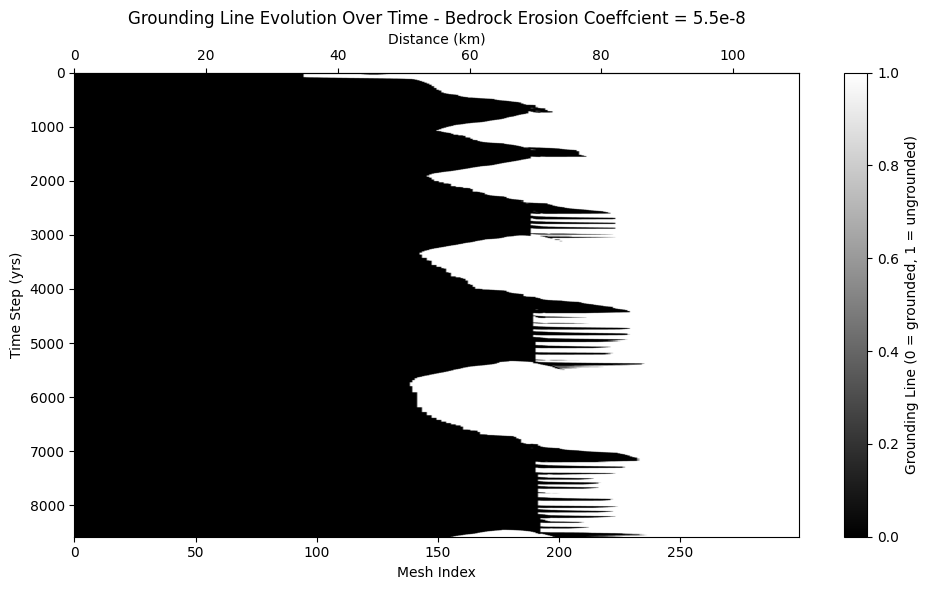

In [22]:
GL_dict = DATA_dict_be_55e8['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_55e8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [23]:
gl_positions_be_55e8 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_55e8.append(idx)

gl_positions_be_55e8 = np.array(gl_positions_be_55e8)
GL_km_be_55e8 = mesh_index_to_km(gl_positions_be_55e8)

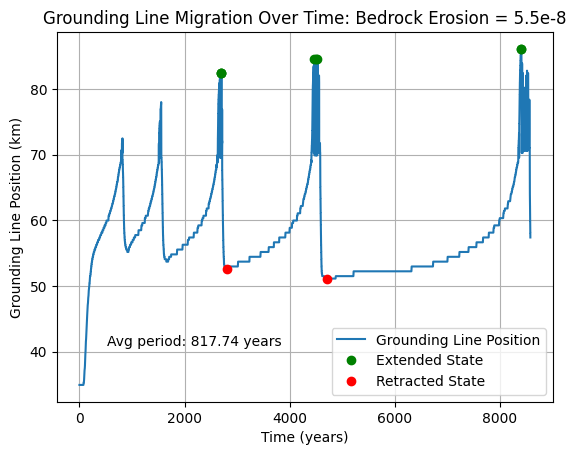

Mean cycle period: 817.74 years
[6.96506590e+00 7.12907389e+00 1.76677189e+03 4.20434008e+01
 1.03757605e+01 3.88723165e+03 3.64990618e+00]
Mean advance amplitude: 84.16 km
[82.40802676 82.40802676 82.40802676 84.61538462 84.61538462 84.61538462
 86.08695652 86.08695652]
Mean retreat amplitude: 51.87 km
[52.60869565 51.13712375]


In [24]:
peaks_be_55e8, _ = find_peaks(GL_km_be_55e8, prominence=25) 
torughs_be_55e8, _ = find_peaks(-GL_km_be_55e8, prominence=25)     
periods_be_55e8 = np.diff(np.array(time)[peaks_be_55e8])
adv_dists_be_55e8 = GL_km_be_55e8[peaks_be_55e8]
ret_dists__be_55e8 = GL_km_be_55e8[torughs_be_55e8]


plt.plot(time, GL_km_be_55e8, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_55e8], GL_km_be_55e8[peaks_be_55e8], 'go', label='Extended State')
plt.plot(np.array(time)[torughs_be_55e8], GL_km_be_55e8[torughs_be_55e8], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_55e8):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 5.5e-8")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_55e8):.2f} years")
print(periods_be_55e8)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_55e8):.2f} km")
print(adv_dists_be_55e8)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_55e8):.2f} km")
print(ret_dists__be_55e8)


Grounding Line plotting - Bedrock Erosion = 1.0 e -7

In [25]:
gl_run_title_be_1e7 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-7")
be_1e7 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run5_be1E-7/DATA_Dictionary_2025_03_24__14_53_22.pkl.gz"
with gzip.open(be_1e7, 'rb') as f:
    DATA_dict_be_1e7 = pickle.load(f)

In [26]:
bed_dict = DATA_dict_be_1e7['bed_dict']
base_dict = DATA_dict_be_1e7['base_dict']
surf_dict= DATA_dict_be_1e7 ['surf_dict']
sed_dict = DATA_dict_be_1e7['sed_dict']
H_dict = DATA_dict_be_1e7['H_dict']
us_dict = DATA_dict_be_1e7['us_dict']
ub_dict = DATA_dict_be_1e7['ub_dict']
Hs_dict = DATA_dict_be_1e7['Hs_dict']
GL_dict = DATA_dict_be_1e7['GL_dict']
Qs_dict = DATA_dict_be_1e7['Qs_dict']

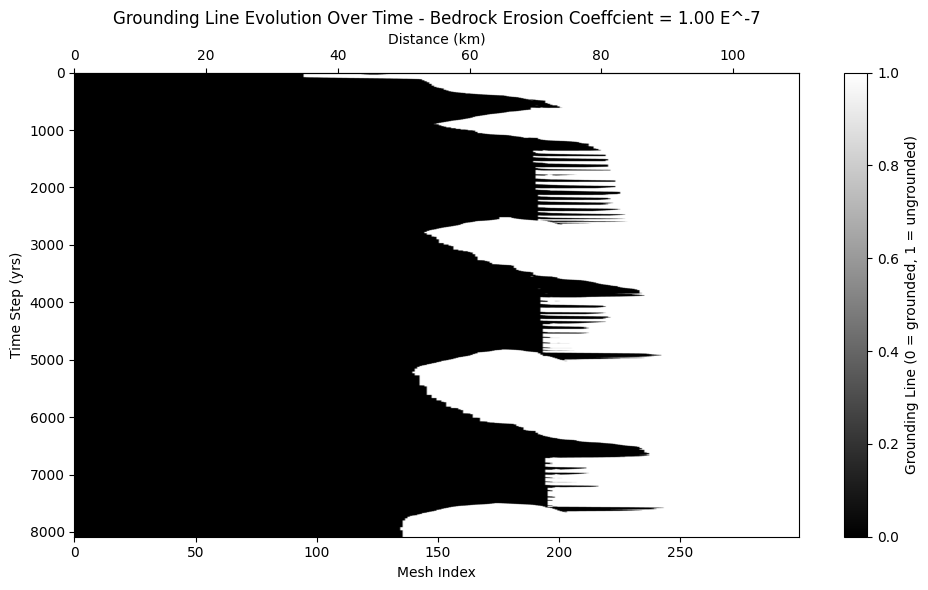

In [27]:
GL_dict = DATA_dict_be_1e7['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e7)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [28]:
gl_positions_be_1e7 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_1e7.append(idx)

gl_positions_be_1e7 = np.array(gl_positions_be_1e7)
GL_km_be_1e7 = mesh_index_to_km(gl_positions_be_1e7)

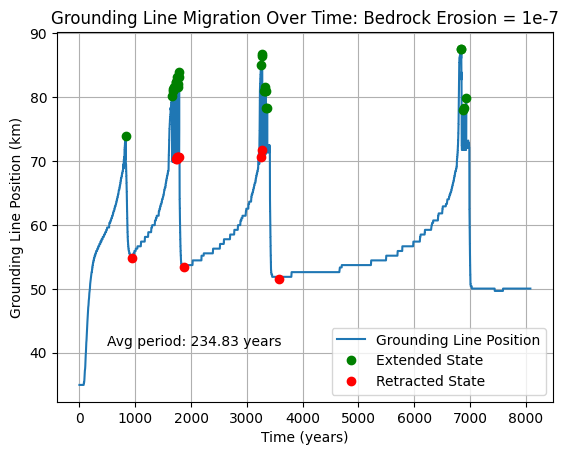

Mean cycle period: 234.83 years
[ 831.44014712   13.35228187    7.81268497    9.36438241   11.70236355
   26.38557081    8.85575989   12.88208159   10.68580885    8.11579261
    9.36373435   10.51323671 1467.59284062   13.39948639    7.18040779
   31.68513736   12.02628497    9.28648367    8.13927327   16.64673291
   11.91096781 3471.36665019    6.97825634   37.80070776   12.74912412
   38.28134848]
Mean advance amplitude: 81.81 km
[73.94648829 80.2006689  80.93645485 81.30434783 81.30434783 81.6722408
 82.40802676 82.40802676 83.14381271 81.6722408  82.04013378 83.14381271
 83.87959866 84.98327759 86.4548495  86.82274247 80.93645485 80.93645485
 81.6722408  80.93645485 78.36120401 78.36120401 87.55852843 87.55852843
 77.99331104 78.36120401 79.83277592]
Mean retreat amplitude: 65.92 km
[54.81605351 70.26755853 70.26755853 70.63545151 70.63545151 70.63545151
 70.63545151 53.34448161 70.63545151 71.73913043 51.50501672]


In [29]:
peaks_be_1e7, _ = find_peaks(GL_km_be_1e7, prominence=6) 
torughs_be_1e7, _ = find_peaks(-GL_km_be_1e7, prominence=12)     
periods_be_1e7 = np.diff(np.array(time)[peaks_be_1e7])
adv_dists_be_1e7 = GL_km_be_1e7[peaks_be_1e7]
ret_dists__be_1e7 = GL_km_be_1e7[torughs_be_1e7]


plt.plot(time, GL_km_be_1e7, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_1e7], GL_km_be_1e7[peaks_be_1e7], 'go', label='Extended State')
plt.plot(np.array(time)[torughs_be_1e7], GL_km_be_1e7[torughs_be_1e7], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_1e7):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 1e-7")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_1e7):.2f} years")
print(periods_be_1e7)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_1e7):.2f} km")
print(adv_dists_be_1e7)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_1e7):.2f} km")
print(ret_dists__be_1e7)


## Relationship Plots

In [61]:
## Bedrock Erosion ##
title_BE_cycles = str("Cycles per 10,000 Years VS Bedrock Erosion")
BEs = np.array([1e-9, 5.5e-9, 1e-8, 5.5e-8, 1e-7])
BE_cycles = np.array([9, 9, 8, 5, 4])
# BE_coeff = np.polyfit(BEs,BE_cycles, 1)
# p_BE = np.poly1d(BE_coeff)
# BE_y_trend = p_BE(BEs)
# R_2_BE =r2_score(BE_cycles,p_BE(BEs))

log_BEs = np.log10(BEs)
slope, intercept, r_value, _, _ = linregress(log_BEs, BE_cycles)
BE_y_trend = slope * log_BEs + intercept


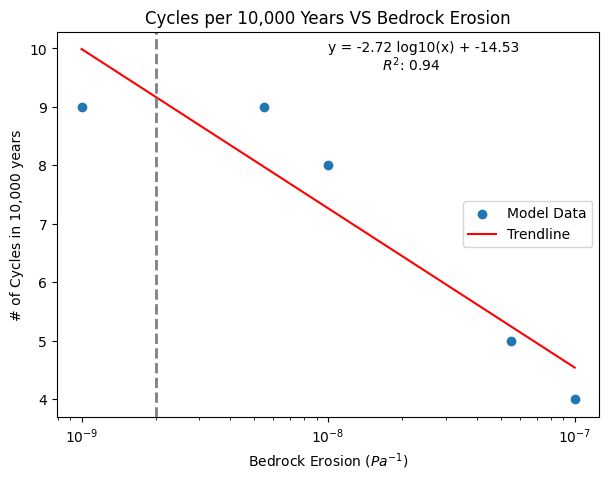

In [72]:
fig, ax1 = plt.subplots(figsize=(7,5))

plt.scatter(BEs, BE_cycles, label = 'Model Data')
plt.title(title_BE_cycles)
plt.plot(BEs, BE_y_trend, color='red', label='Trendline')
plt.text(0.6, 0.9, f'$R^2$: {R_2_BE:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.95, f'y = {slope:.2f} log10(x) + {intercept:.2f}', transform=plt.gca().transAxes)
plt.axvline(x=2e-9, color='gray', linestyle='--', linewidth=2)
plt.xlabel("Bedrock Erosion ($Pa^{-1}$)")
plt.xscale('log')
plt.ylabel("# of Cycles in 10,000 years")
plt.legend()
# plt.xticks(np.arange(1e-9, 1e-8, 1e-7)) 

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/BedrockErosion/Relationship_Plots/#ofCycles_BE.svg", format ="svg", bbox_inches='tight')

In [73]:
Period_list = [periods_be_1e9, periods_be_55e9, periods_be_1e8, periods_be_55e8, periods_be_1e7]

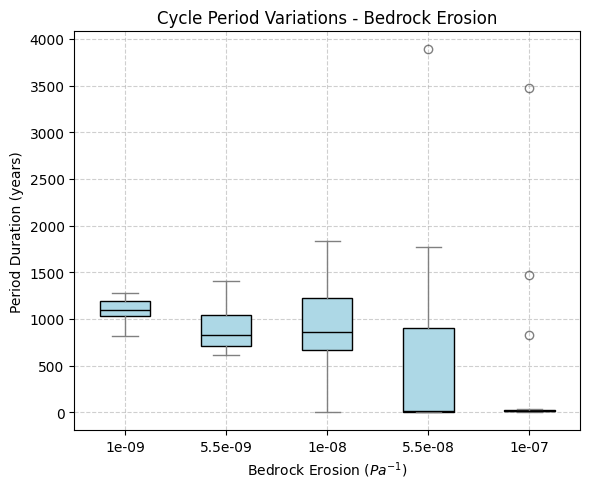

In [86]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(Period_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Cycle Period Variations - Bedrock Erosion")
ax.set_ylabel("Period Duration (years)")
ax.set_xlabel("Bedrock Erosion ($Pa^{-1}$)")
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/BedrockErosion/Relationship_Plots/PeriodVariation_BE.svg", format ="svg", bbox_inches='tight')

In [81]:
ExtPos_list =  [adv_dists_be_1e9, adv_dists_be_55e9, adv_dists_be_1e8,adv_dists_be_55e8, adv_dists_be_1e9]


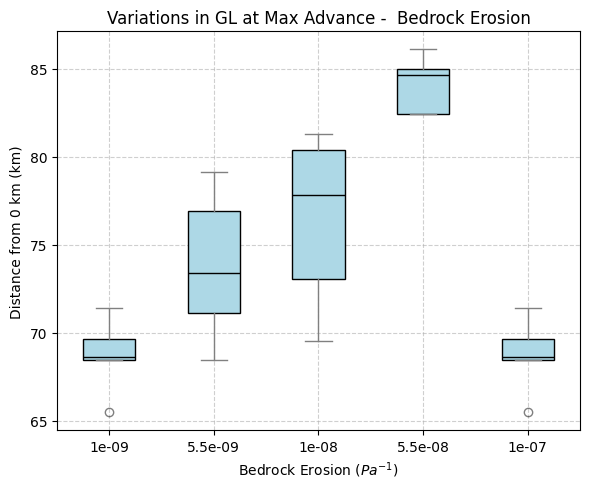

In [83]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Max Advance -  Bedrock Erosion")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Bedrock Erosion ($Pa^{-1}$)")
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [75]:
RetPos_list =  [ret_dists__be_1e9, ret_dists__be_55e9, ret_dists__be_1e8, ret_dists__be_55e8,  ret_dists__be_1e9, ]

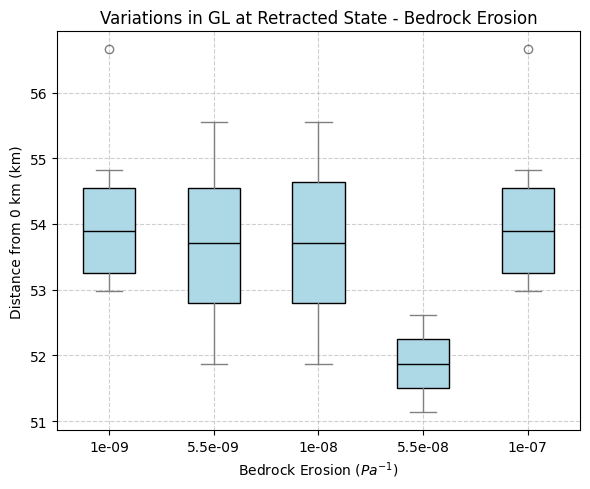

In [78]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Retracted State - Bedrock Erosion")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Bedrock Erosion ($Pa^{-1}$)")
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

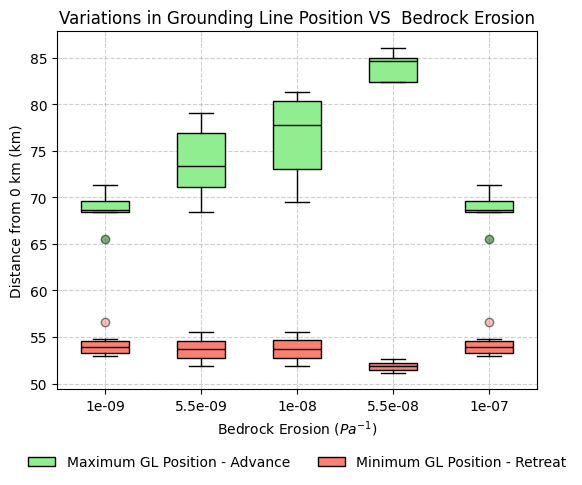

In [87]:
fig, ax = plt.subplots(figsize=(6, 5))

D2 = ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='salmon'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='salmon', alpha=0.5))

D1 = ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightgreen'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='darkgreen', alpha=0.5))

ax.set_title("Variations in Grounding Line Position VS  Bedrock Erosion")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Bedrock Erosion ($Pa^{-1}$)")
ax.legend([D1["boxes"][0], D2["boxes"][0]], ['Maximum GL Position - Advance', 'Minimum GL Position - Retreat'], loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, frameon=False)
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/BedrockErosion/Relationship_Plots/GL_Variation_BE.svg", format ="svg", bbox_inches='tight')